# Week 8 - Training a Language Model with Attention 

This week, we add an attention mechanism to our model. This notebook is a shortened version by Sebastian Rascha's notebook: https://github.com/rasbt/LLMs-from-scratch/blob/main/ch03/01_main-chapter-code/ch03.ipynb 

## 1. Setting up data and model

In [34]:
print("Hallo")

Hallo


In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tiktoken
from importlib.metadata import version
import math
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.3.1.post300
tiktoken version: 0.8.0


### 1.1 Data preparation
The steps are the same as last week. 

In [28]:
#from src.helper  import
from src.helper import get_cleaned_spanish_text_as_string, clean_text_spanish_remove,get_lines_without_number,clean_spanish_text,get_cleaned_text

text_path = "content/spa_wikipedia_2021_30K-sentences.txt"
path_to_save_folder= "model/attent_data"

#raw_text = get_cleaned_spanish_text_as_string(text_path)
#enc_text = tokenizer.encode(raw_text)

# Load the text data
raw_text = get_cleaned_spanish_text_as_string(text_path) #Standart 
#raw_text = get_cleaned_text(text_path,clean_text_spanish_remove)

tokenizer = tiktoken.get_encoding("gpt2")

# Tokenize the text
token_ids = tokenizer.encode(raw_text)

print("Total number of tokens:", len(token_ids))
print("First 10 tokens:", token_ids[:10])
print("Text size: ",len(raw_text))

Total lines replaced 30000
Total number of tokens: 1221649
First 10 tokens: [1105, 390, 450, 22379, 390, 8235, 1658, 555, 64, 719]
Text size:  3701778


In [29]:

from src.dataset import GPTDataset
from src.dataset import create_dataloader

### 1.2 Initializing a model

We set up our model. We add a second layer and a non-linear activation function.  

In [9]:
from src.model import LanguageModel

## 2. Implementing Self-Attention

We'll implement self-attention step by step, starting with the basic computations.

### 3.1 Computing Attention Scores

For each token in the sequence, we compute Query, Key, and Value vectors using learnable weight matrices.

In [10]:
from src.attentionModel import SelfAttention

### 3.2 Masking for Causal Attention

In language models, we often use causal (or masked) attention to prevent the model from attending to future tokens.

In [11]:
from src.attentionModel import CausalSelfAttention

## 3. Extending to multi-head attention

Multi-head attention allows the model to attend to information from different representation subspaces at different positions.

In [12]:
from src.attentionModel import MultiHeadCausalAttention

## 4. Adding attention to the model

Now, we'll update our model to include the multi-head causal attention layer.

In [13]:
from src.attentionModel import LanguageModelWithAttention

## 5. Training and evaluation

We'll train the modified model and evaluate its performance.

### 5.1 Setting up training parameters

In [31]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 16 #Standard 32 
context_length = 32  # Increased context size
vocab_size = tokenizer.n_vocab
embedding_dim = 128
attention_dim = 64
hidden_dim = 64
num_heads = 4

# Create the DataLoader
train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
    raw_text, batch_size=batch_size, 
    context_length=context_length,     shuffle=True
)



Using device: cuda


In [32]:
# Initialize the model
model = LanguageModelWithAttention(
    vocab_size, embedding_dim, attention_dim, context_length, hidden_dim, num_heads, dropout=0.2
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters'
num_epochs = 4
data_loader = train_dataloader

print_every = 75
evaluate_every = 3000
train_run_label = "basic_att_batchsize16_ep4"

### 5.2 Training the model

In [33]:
from src.train import train_attention
#(all_losses,train_losses,perplexities) = train_attention(model,num_epochs,optimizer,criterion,data_loader,path_to_save_folder,
#                                               train_run_label,vocab_size,device,print_every)

(all_losses,train_losses,perplexities,all_perplex) = train_attention(model,num_epochs,optimizer,criterion,data_loader,path_to_save_folder,train_run_label,vocab_size,device,evaluate_every,dev_dataloader,print_every)

Started Training
Epoch [1/4], Step [0/61080], Loss: 10.8473
Validation perplexity: 50540.22227627894
Epoch [1/4], Step [75/61080], Loss: 6.8057
Epoch [1/4], Step [150/61080], Loss: 6.9529
Epoch [1/4], Step [225/61080], Loss: 6.7151
Epoch [1/4], Step [300/61080], Loss: 6.5713
Epoch [1/4], Step [375/61080], Loss: 6.7121
Epoch [1/4], Step [450/61080], Loss: 6.5298
Epoch [1/4], Step [525/61080], Loss: 6.4536
Epoch [1/4], Step [600/61080], Loss: 6.5191
Epoch [1/4], Step [675/61080], Loss: 6.8836
Epoch [1/4], Step [750/61080], Loss: 6.4027
Epoch [1/4], Step [825/61080], Loss: 5.9638
Epoch [1/4], Step [900/61080], Loss: 6.1015
Epoch [1/4], Step [975/61080], Loss: 6.1614
Epoch [1/4], Step [1050/61080], Loss: 6.0849
Epoch [1/4], Step [1125/61080], Loss: 5.6714
Epoch [1/4], Step [1200/61080], Loss: 5.7513
Epoch [1/4], Step [1275/61080], Loss: 5.7572
Epoch [1/4], Step [1350/61080], Loss: 5.5538
Epoch [1/4], Step [1425/61080], Loss: 5.8570
Epoch [1/4], Step [1500/61080], Loss: 5.6207
Epoch [1/4], 

In [18]:
#To read old results 
#read_list_from_file(label,path_to_save_folder)
from src.helper import read_list_from_file
#train_losses=read_list_from_file("onlyLossesUntil3593",path_to_save_folder)
#perplexities= read_list_from_file("normal_model_perplexities",path_to_save_folder)

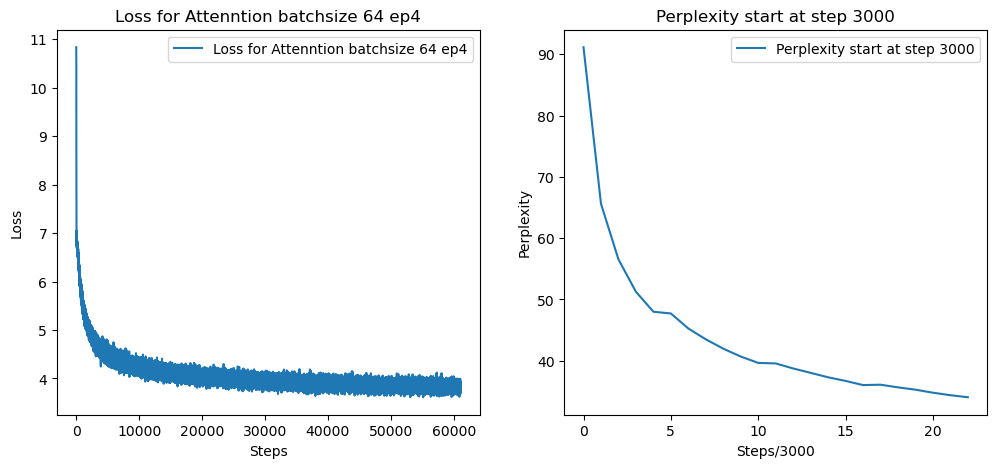

In [25]:
from src.plot import plot_two
plot_two(all_losses,"Loss for Attenntion batchsize 64 ep4",all_perplex[1:],"Perplexity start at step 3000",axLabel1=("Steps","Loss"),axLabel2=("Steps/3000","Perplexity"), save = True)

### 5.3 Evaluating the model

In [12]:
from src.train import evaluate_attention
import time
t0 = time.time()
perplexity_simple = evaluate_attention(model, dev_dataloader,criterion,device,vocab_size)
t1 = time.time()
print(t1-t0)
print(f"Perplexity ofthe model with attention: {perplexity_simple:.2f}")

9.422146797180176
Perplexity ofthe model with attention: 46.74


### 5.4 Generating text

Generate text and analyse how different temperature settings affect the generated text. 

In [21]:
def generate_text(model, tokenizer, start_text, context_length=32, temperature=1.0):
    model.eval()
    generated = tokenizer.encode(start_text)
    context = torch.tensor(generated, dtype=torch.long,
                          device=device).unsqueeze(0)
    
    with torch.no_grad():
        for _ in range(context_length):
            if context.size(1) >= context_length:
                break
            logits, _ = model(context)
            next_token_logits = logits[0, -1, :] / temperature
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            context = torch.cat(
                [context, next_token_id.unsqueeze(0)], dim=1
            )
    
    generated_text = tokenizer.decode(context[0].tolist())
    return generated_text

start_text = "Jim was"
generated_text = generate_text(model, tokenizer, start_text, context_length=32)
print("Generated Text:\n")
print(generated_text)

Generated Text:

Jim was Hammasky Mal limal Niidencial. La sonidad se encontró colaboración con la superficie de los


In [22]:
#def generate_text_attention(model, tokenizer, start_text,device, context_length=32, temperature=1.0):
from src.attentionModel import generate_text_attention


start_text = "Esto es "

for x in range(10):
    text = generate_text_attention(model, tokenizer, start_text,device, context_length=32, temperature=1.0)
    print(text)


start_text = "A los artistas se les"
print("\n\nNew Beginning")

for x in range(10):
    text = generate_text_attention(model, tokenizer, start_text,device, context_length=32, temperature=1.0)
    print(text)

Esto es  El arma del calista que elfreque de Warren French fue posteriormente se preferentes con Yamaha. Cuando a Miles
Esto es  regla lógicas y participación estructura hasta de importante en la isla natural no consorciá
Esto es  y teatro ranuras comparación propar con a la es vasta en la que comien solo tratamiento civil
Esto es  2 había tenido aprobos la de Vishio en todo es un radio a Poe o lanzada del Che
Esto es ir que habían al lugar sus dirigidosivosiciados por LSes 4 antedó en programar
Esto es  en al05 observaron que los localidad retirérito realizó por las estaciones meveniores en La car
Esto es icos poemado para filmar al considerar el juego perdairos al mismo de tipo en unorte
Esto es iba a dos historias literarios pasados mezas tutela y Y Nechesor vital de 2004 junio arrendizada
Esto es  con una competionado una mediante investigación federalizada en varios escala. Cox Tu de diput
Esto es  Monde parte 23 millones de cumplaz. Posteriormente llegó a los misioneros52000 expu

# Training Runs

In [ ]:
#This cell is not yet tested 

from src.trainComplete import TrainComplete
from src.attentionModel import LanguageModelWithAttention

trainclass = TrainComplete(text_path = text_path,path_to_save_folder= path_to_save_folder,
                            is_attention_training = True)


context_length = 32  # Increased context size
embedding_dim = 128
attention_dim = 64
hidden_dim = 64
num_heads = 4

model = LanguageModelWithAttention(
    vocab_size, embedding_dim, attention_dim, context_length, hidden_dim, num_heads, dropout=0.2
).to(device)

trainclass.train(model,
              vocab_size,device,raw_text,"span_attention_standard_dropout_ep5_eval10000",
                print_every=75,evaluate_every=10000,optimizer=None,criterion=None,
              batch_size = 32,
              embedding_dim = embedding_dim,
              context_length = context_length,
              num_epochs = 10
             )

# Extra Trainining Runs

Not all the training Runs are still here in the Cells. That are just examples how the training Runs where Performed 

In [26]:
#from src.helper  import
from src.helper import get_cleaned_spanish_text_as_string, clean_text_spanish_remove,get_lines_without_number,clean_spanish_text,get_cleaned_text
from src.helper import clean_text_spanish_both,clean_text_both,get_cleaned_spanish_text_as_string,clean_text_spanish_remove,get_lines_without_number,clean_spanish_text,get_cleaned_text

text_path = "content/spa_wikipedia_2021_30K-sentences.txt"
path_to_save_folder= "model/attent_data"

#raw_text = get_cleaned_spanish_text_as_string(text_path)
#enc_text = tokenizer.encode(raw_text)

# Load the text data
#raw_text = get_cleaned_spanish_text_as_string(text_path) #Standart 
raw_text = get_cleaned_text(text_path,clean_text_spanish_remove)

tokenizer = tiktoken.get_encoding("gpt2")

# Tokenize the text
token_ids = tokenizer.encode(raw_text)

print("Total number of tokens:", len(token_ids))
print("First 10 tokens:", token_ids[:10])
print("Text size: ",len(raw_text))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 32 #Standard 32 
context_length = 32  # Increased context size
vocab_size = tokenizer.n_vocab
embedding_dim = 128
attention_dim = 64
hidden_dim = 64
num_heads = 4

# Create the DataLoader
train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
    raw_text, batch_size=batch_size, 
    context_length=context_length,     shuffle=True
)


# Initialize the model
model = LanguageModelWithAttention(
    vocab_size, embedding_dim, attention_dim, context_length, hidden_dim, num_heads, dropout=0.2
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters'
num_epochs = 4
data_loader = train_dataloader

print_every = 75
evaluate_every = 3000
train_run_label = "basic_att_preprocessingRemove"

from src.train import train_attention
#(all_losses,train_losses,perplexities) = train_attention(model,num_epochs,optimizer,criterion,data_loader,path_to_save_folder,
#                                               train_run_label,vocab_size,device,print_every)

(all_losses,train_losses,perplexities,all_perplex) = train_attention(model,num_epochs,optimizer,criterion,data_loader,path_to_save_folder,train_run_label,vocab_size,device,evaluate_every,dev_dataloader,print_every)

Total lines not removed :  28494
Total number of tokens: 1203707
First 10 tokens: [26, 1105, 390, 450, 22379, 390, 8235, 8, 1658, 555]
Text size:  3580198
Using device: cuda
Started Training
Epoch [1/4], Step [0/30091], Loss: 10.8321
Validation perplexity: 50302.159157561706
Epoch [1/4], Step [75/30091], Loss: 6.8627
Epoch [1/4], Step [150/30091], Loss: 6.6438
Epoch [1/4], Step [225/30091], Loss: 6.6587
Epoch [1/4], Step [300/30091], Loss: 6.6822
Epoch [1/4], Step [375/30091], Loss: 6.6268
Epoch [1/4], Step [450/30091], Loss: 6.4403
Epoch [1/4], Step [525/30091], Loss: 6.2252
Epoch [1/4], Step [600/30091], Loss: 6.0489
Epoch [1/4], Step [675/30091], Loss: 6.2441
Epoch [1/4], Step [750/30091], Loss: 5.9548
Epoch [1/4], Step [825/30091], Loss: 6.0237
Epoch [1/4], Step [900/30091], Loss: 5.8269
Epoch [1/4], Step [975/30091], Loss: 5.5972
Epoch [1/4], Step [1050/30091], Loss: 5.8031
Epoch [1/4], Step [1125/30091], Loss: 5.6343
Epoch [1/4], Step [1200/30091], Loss: 5.6371
Epoch [1/4], Step 

# Another one 

In [27]:
#from src.helper  import
from src.helper import get_cleaned_spanish_text_as_string, clean_text_spanish_remove,get_lines_without_number,clean_spanish_text,get_cleaned_text
from src.helper import clean_text_spanish_both,clean_text_both,get_cleaned_spanish_text_as_string,clean_text_spanish_remove,get_lines_without_number,clean_spanish_text,get_cleaned_text

text_path = "content/spa_wikipedia_2021_30K-sentences.txt"
path_to_save_folder= "model/attent_data"

#raw_text = get_cleaned_spanish_text_as_string(text_path)
#enc_text = tokenizer.encode(raw_text)

# Load the text data
#raw_text = get_cleaned_spanish_text_as_string(text_path) #Standart 
raw_text =  get_cleaned_text(text_path,clean_text_spanish_both)

tokenizer = tiktoken.get_encoding("gpt2")

# Tokenize the text
token_ids = tokenizer.encode(raw_text)

print("Total number of tokens:", len(token_ids))
print("First 10 tokens:", token_ids[:10])
print("Text size: ",len(raw_text))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 32 #Standard 32 
context_length = 32  # Increased context size
vocab_size = tokenizer.n_vocab
embedding_dim = 128
attention_dim = 64
hidden_dim = 64
num_heads = 4

# Create the DataLoader
train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
    raw_text, batch_size=batch_size, 
    context_length=context_length,     shuffle=True
)


# Initialize the model
model = LanguageModelWithAttention(
    vocab_size, embedding_dim, attention_dim, context_length, hidden_dim, num_heads, dropout=0.2
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters'
num_epochs = 4
data_loader = train_dataloader

print_every = 75
evaluate_every = 3000
train_run_label = "basic_att_preprocessingBoth"

from src.train import train_attention
#(all_losses,train_losses,perplexities) = train_attention(model,num_epochs,optimizer,criterion,data_loader,path_to_save_folder,
#                                               train_run_label,vocab_size,device,print_every)

(all_losses,train_losses,perplexities,all_perplex) = train_attention(model,num_epochs,optimizer,criterion,data_loader,path_to_save_folder,train_run_label,vocab_size,device,evaluate_every,dev_dataloader,print_every)

Total lines not removed :  28494
Total lines replaced 28494
Total number of tokens: 1127637
First 10 tokens: [1105, 390, 450, 22379, 390, 8235, 1658, 555, 64, 719]
Text size:  3475552
Using device: cuda
Started Training
Epoch [1/4], Step [0/28190], Loss: 10.8310
Validation perplexity: 49869.324770656036
Epoch [1/4], Step [75/28190], Loss: 6.9254
Epoch [1/4], Step [150/28190], Loss: 6.7594
Epoch [1/4], Step [225/28190], Loss: 6.6811
Epoch [1/4], Step [300/28190], Loss: 6.8016
Epoch [1/4], Step [375/28190], Loss: 6.6541
Epoch [1/4], Step [450/28190], Loss: 6.5188
Epoch [1/4], Step [525/28190], Loss: 6.4779
Epoch [1/4], Step [600/28190], Loss: 6.3179
Epoch [1/4], Step [675/28190], Loss: 6.2427
Epoch [1/4], Step [750/28190], Loss: 6.0403
Epoch [1/4], Step [825/28190], Loss: 5.9730
Epoch [1/4], Step [900/28190], Loss: 5.8638
Epoch [1/4], Step [975/28190], Loss: 5.9628
Epoch [1/4], Step [1050/28190], Loss: 5.8493
Epoch [1/4], Step [1125/28190], Loss: 5.6870
Epoch [1/4], Step [1200/28190], Lo